# Movie Data Scraping

## Part 1. Scraping from IMDB

In [4]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import requests
from dateutil.parser import parse

In [16]:
def crawl()->list:
    base_url = 'https://www.imdb.com/'
    html = requests.get("https://www.imdb.com/chart/top?ref_=nv_mv_250").text
    soup = BeautifulSoup(html, 'lxml')
    movie_table = soup.tbody
    return [base_url + movie_row.td.a['href'] for movie_row in movie_table.findAll('tr')]
    
movie_links = crawl()

In [18]:
ratings = ["PG-13", "R", "PG", "G", 'Not Rated']
genres = ['Action', 'Adventure', 'Sci-Fi', 'Family', 'Drama', 'Romance', 'War', 'Thriller', 'Crime', 'Mystery', 'Comedy']

def prep_df()->pd.DataFrame:
    return pd.DataFrame(columns=['title', 'rating', 'genre', 'release_date', 'ranking',
                         'director', 'cast', 'budget', 'runtime', 'cum_worldwide_gross'])

def is_date(string):
    try: 
        parse(string)
        return True
    except ValueError:
        return False

def parse_dollars(x:str)->str:
    return ''.join(x.split('$')[1].split(' ')[0].strip().split(','))
    
def populate_df()->pd.DataFrame:
    df = prep_df()
    for link in movie_links:
        html = requests.get(link).text
        soup = BeautifulSoup(html, 'lxml')
        title=rating=genre=release_date=ranking=director=cast=budget=runtime=cum_worldwide_gross=np.nan
        main_top = soup.find('div', {'id': 'main_top'})
        main_bottom = soup.find('div', {'id': 'main_bottom'})
        title = main_top.h1.text.split('(')[0]
        info_bar = main_top.find('div', {'class': 'subtext'}).text.split('|')
        for element in info_bar:
            if element.strip() in ["PG-13", 'R', "PG", 'G']:
                rating = element.strip()
            elif element.strip().split(',')[0] in genres: 
                genre = ';'.join(element.strip().split(','))
            elif is_date(element.strip().split('(')[0].strip()):
                release_date = element.strip().split('(')[0].strip()
            else:
                continue
        ranking_wrapper = main_top.find('div', {'class': 'ratings_wrapper'})
        ranking = ranking_wrapper.find('span', {'itemprop': 'ratingValue'}).text if ranking_wrapper != None else np.nan
        for item in main_top.findAll('div', {'class': 'credit_summary_item'}):
            if item.h4.text == 'Director:':
                director = item.a.text
        cast_members = list()
        for cast_mem in main_bottom.findAll('tr', {'class': ['odd', 'even']}):
            cast_members.append(cast_mem.find('td', {'class': False}).a.text.strip())
        cast = ';'.join(cast_members)
        for x in main_bottom.find('div', {'id':'titleDetails'}).findAll('div', {'class':'txt-block'}):
            try:
                if x.h4.text == 'Budget:':
                    budget = parse_dollars(x.text)
                elif 'Cumulative' in x.h4.text:
                    cum_worldwide_gross = parse_dollars(x.text)
                elif 'Runtime' in x.h4.text:
                    runtime = x.text.split()[1].strip()
            except:
                pass
        newRow = pd.Series({'title': title, 'rating': rating, 'genre': genre, 'release_date': release_date, 'ranking': ranking, 
                   'director': director, 'cast': cast, 'budget': budget, 'runtime': runtime, 
                   'cum_worldwide_gross': cum_worldwide_gross})
        df = df.append(newRow, ignore_index=True)
    return df

df = populate_df()

In [20]:
df.to_csv(path_or_buf='./movies.csv')

## Part 2. Data Visualization

In [140]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [141]:
movies = pd.read_csv('movies.csv')
movies = movies[movies.columns[1:]]

In [142]:
movies['profit'] = movies.apply(lambda row: row.cum_worldwide_gross - row.budget, axis=1)
movies['year'] = movies.apply(lambda row: row.release_date.split()[-1], axis=1)
movies.head()

,title,rating,genre,release_date,ranking,director,cast,budget,runtime,cum_worldwide_gross,profit,year
0,The Shawshank Redemption,NaN,Drama,14 October 1994,9.3,Frank Darabont,Tim Robbins;Morgan Freeman;Bob Gunton;William ...,25000000.0,142.0,5.850000e+07,33500000.0,1994
1,The Godfather,NaN,Crime; \nDrama,24 March 1972,9.2,Francis Ford Coppola,Marlon Brando;Al Pacino;James Caan;Richard S. ...,6000000.0,175.0,2.450664e+08,239066411.0,1972
2,The Godfather: Part II,PG,Crime; \nDrama,20 December 1974,9.0,Francis Ford Coppola,Al Pacino;Robert Duvall;Diane Keaton;Robert De...,13000000.0,202.0,NaN,NaN,1974
3,The Dark Knight,PG,Action; \nCrime; \nDrama,18 July 2008,9.0,Christopher Nolan,Christian Bale;Heath Ledger;Aaron Eckhart;Mich...,185000000.0,152.0,1.004558e+09,819558444.0,2008
4,12 Angry Men,PG,Drama,April 1957,8.9,Sidney Lumet,Martin Balsam;John Fiedler;Lee J. Cobb;E.G. Ma...,350000.0,96.0,NaN,NaN,1957


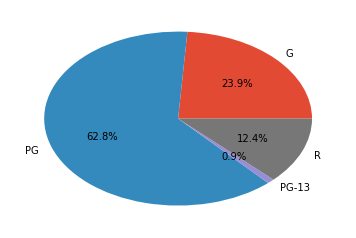

In [143]:
ratings = movies.groupby('rating').count()['title']
plt.pie(ratings, autopct='%1.1f%%', labels=ratings.index.values)
plt.show()

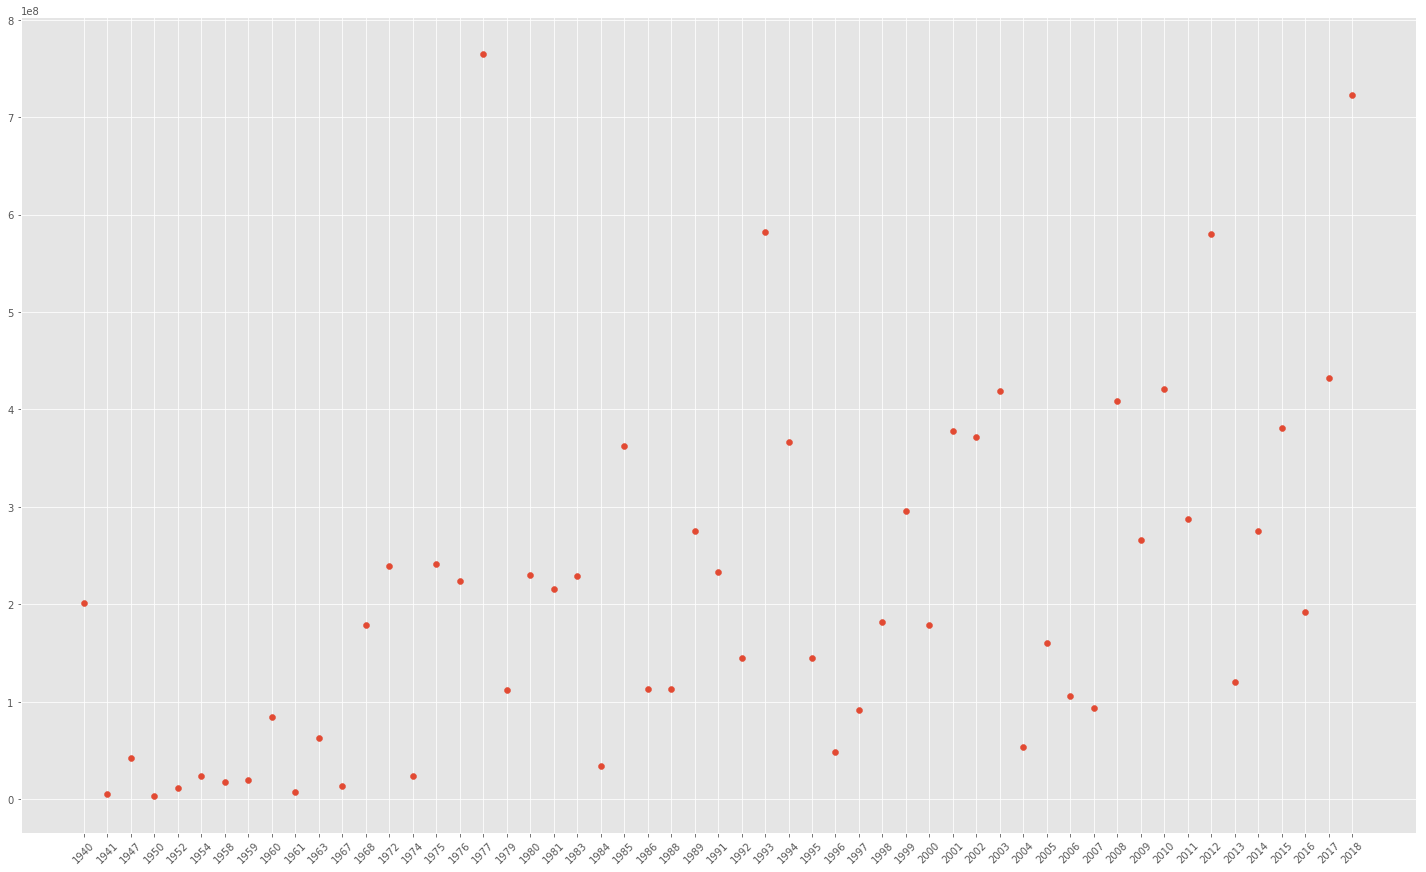

In [146]:
profit = movies.groupby('year').mean()
profit.sort_values(by=['year'], inplace=True)
profit = profit.dropna(subset=['profit'])
profit = profit[['profit']]
# profit.plot(kind='bar', rot=45, figsize=(20, 6))
plt.figure(figsize=(25,15))
plt.xticks(rotation=45)
plt.scatter(x=profit.index.values, y=profit['profit'])

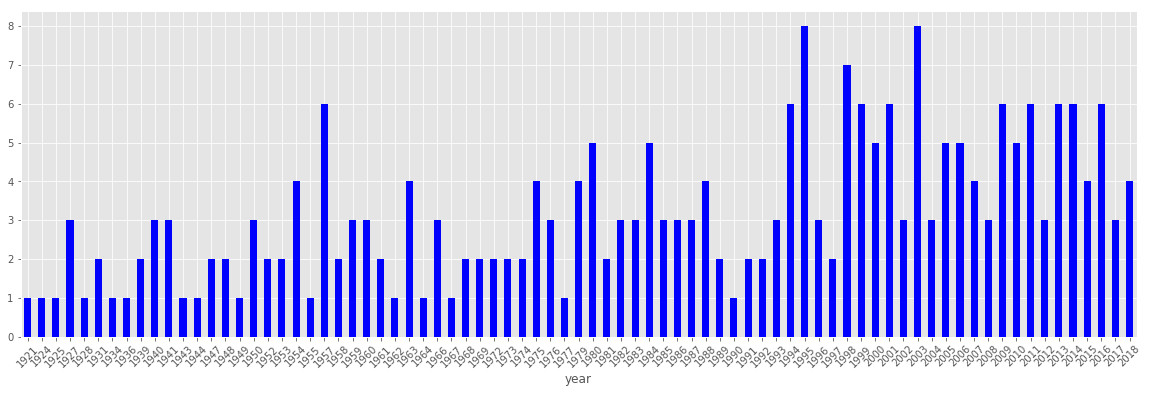

In [117]:
dates = movies.groupby('year').count()['title']
dates.plot(kind='bar', rot=45, figsize=(20, 6), color='blue')

Text(0,0.5,'Profit')

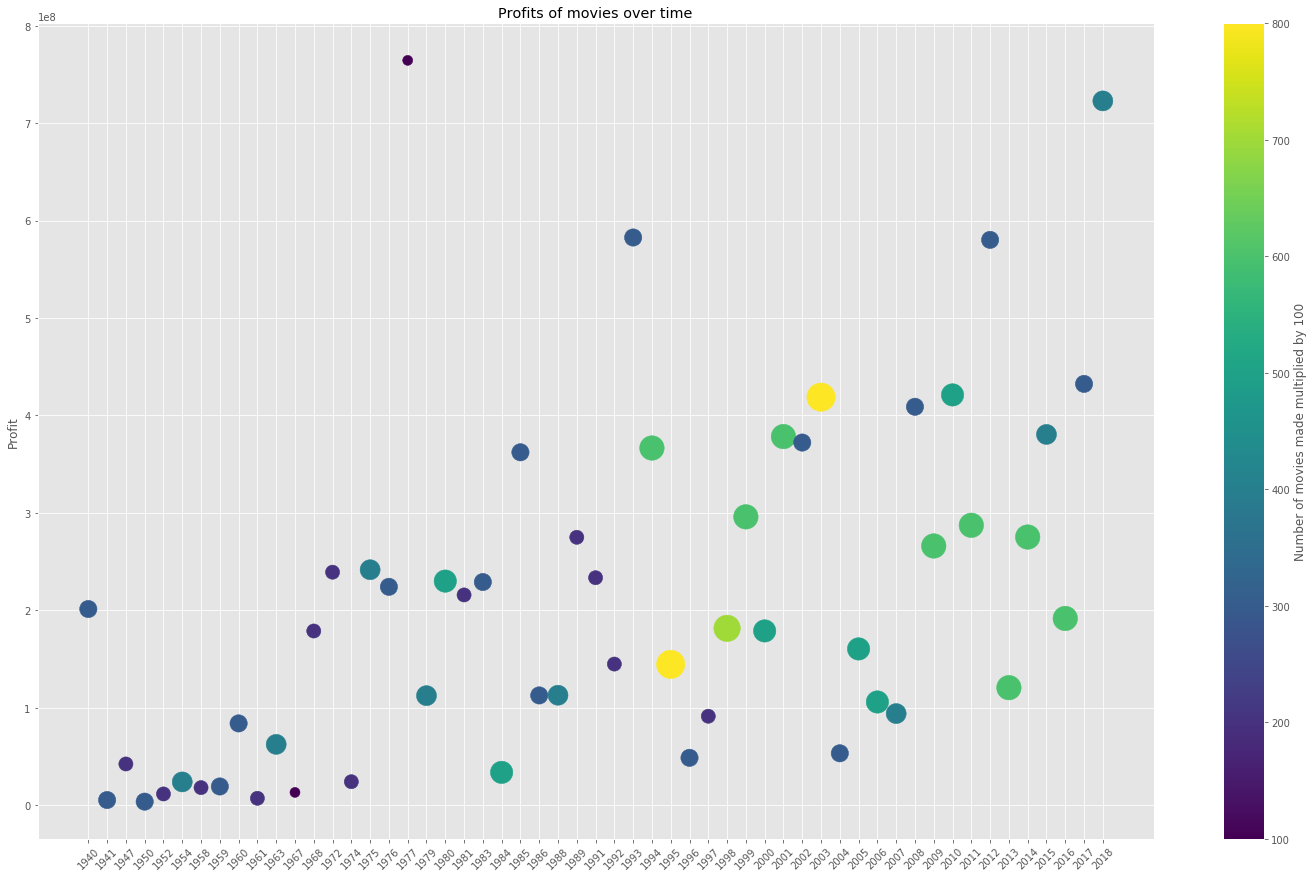

In [163]:
x = profit.reset_index().merge(dates.reset_index())
x['num_made'] = x.apply(lambda row: row.title*100, axis=1)
plt.figure(figsize=(25,15))
plt.xticks(rotation=45)
plt.scatter(x=x['year'], y=x['profit'], s=x['num_made'], c=x['num_made'])
plt.colorbar(label='Number of movies made multiplied by 100')
plt.title('Profits of movies over time')
plt.ylabel('Profit')